# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
spm_li = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
    }
)

spme = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme_li = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
cell = 4
sno = 6
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
    # New Mech Damage Model
par_val[6]=[2.056E-07,2.4664E-06,1.2468,1.0482e-09]

In [6]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
c_rate_d ='C/5'
SOC_0 = 0

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# pybamm.set_logging_level("INFO")
# pybamm.set_logging_level("VERBOSE")
# pybamm.set_logging_level("SPAM")
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
SOC_0 = 0 

# experiment = pybamm.Experiment(
#     [
#         (
#         #  "Charge at "+c_rate_c+" until 4.2V", 
#         #  "Hold at 4.2V until C/50",
#         #  "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 1

In [9]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

# sim_long1 = pybamm.Simulation(spme_li, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long1 = sim_long1.solve(initial_soc=SOC_0)
# solution1_e = sol_long1

2023-02-06 09:37:16.363 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (13.225 ms elapsed) --------------------
2023-02-06 09:37:16.364 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at C/5 until 4.2V
2023-02-06 09:37:16.612 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-02-06 09:37:16.726 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2023-02-06 09:37:16.771 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at C/5 until 3V
2023-02-06 09:37:17.168 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.847 Ah (originally 4.847 Ah, will stop at 2.424 Ah)
2023-02-06 09:37:17.169 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 817.984 ms


In [10]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
c_rate_c ='1.5C'
c_rate_d ='1.5C'
# c_rate_c ='2C'
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
SOC_0 = 0 

sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

# sim_long1 = pybamm.Simulation(spme_li, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long1 = sim_long1.solve(initial_soc=SOC_0)
# solution2_e = sol_long1

2023-02-06 09:37:18.847 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (13.412 ms elapsed) --------------------
2023-02-06 09:37:18.848 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at 1.5C until 4.2V
2023-02-06 09:37:18.950 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-02-06 09:37:19.070 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2023-02-06 09:37:19.124 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at 1.5C until 3V
2023-02-06 09:37:19.372 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.844 Ah (originally 4.844 Ah, will stop at 2.422 Ah)
2023-02-06 09:37:19.373 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 539.133 ms


In [11]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    # phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_seif = []
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    phi_sei  = []
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration"].entries
    c_save_n1 = solution["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration"].entries

    u_css_n = solution["X-averaged negative electrode open circuit potential [V]"].entries

    # j_pl = solution["Negative electrode lithium plating interfacial current density [A.m-2]"].entries
    j_pl = []
    # eta_pl = solution["Negative electrode lithium plating reaction overpotential [V]"].entries
    eta_pl = []
    sigma_ts_n = solution["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_ts_p = solution["X-averaged positive particle surface tangential stress [Pa]"].entries

    C_n = solution["Negative electrode capacity [A.h]"].entries
    C_p = solution["Positive electrode capacity [A.h]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n,u_css_n,j_pl,eta_pl,sigma_ts_n,C_n,sigma_ts_p,C_p

In [12]:
# fig, axes = plt.subplots(2, 3, figsize=(8, 6))
# ax1 = axes.flat[0]
# ax1.plot(t1,V1,'b')
# ax1.plot(t2,V2,'rv-')
# ax1.set_title('Voltage [V]')
# ax3 = axes.flat[3]
# ax3.plot(t1,phi_pl1,'b')
# ax3.plot(t2,phi_pl2,'rv-')
# ax3.set_ylim([-0.1,1])
# ax3.set_title('Plating Overpotential [V]')
# ax4 = axes.flat[5]
# ax4.plot(t1,phi_sei1,'b')
# ax4.plot(t2,phi_sei2,'rv-')
# # ax4.set_ylim([-0.1,1])
# ax4.set_title('SEI Overpotential [V]')
# ax2 = axes.flat[2]
# ax2.plot(t1,Q_Li1,'b')
# ax2.plot(t2,Q_Li2,'rv-')
# ax2.set_title('Capacity lost due to plating [Ah]')
# ax6=axes.flat[1]
# ax6.plot(t1,I_Li1,'b')
# ax6.plot(t2,I_Li2,'rv-')
# ax6.set_title('Lithium plating interfacial current density')
# ax5=axes.flat[4]
# ax5.plot(t1,phi_del1,'b')
# ax5.plot(t2,phi_del2,'rv-')
# ax5.set_ylim([-0.1,1])

# ax1.plot(t3,V3,'g--')
# ax3.plot(t3,phi_pl3,'g--')
# ax4.plot(t3,phi_sei3,'g--')
# ax2.plot(t3,Q_Li3,'g--')
# ax6.plot(t3,I_Li3,'g--')
# ax5.plot(t3,phi_del3,'g--')
# ax5.set_title('Neg Elec Surf Pot Diff [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','New Params'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [13]:
# fig, axes = plt.subplots(3, 1, figsize=(6,8))
# ax1 = axes.flat[0]
# ax1.plot(Q1,phi_ocp1,'b')
# ax1.plot(Q2,phi_ocp2,'rv-')
# ax1.set_title('Negative Electrode Open Circuit Potential [V]')
# ax2 = axes.flat[1]
# ax2.plot(Q1,phi_int1,'b')
# ax2.plot(Q2,phi_int2,'rv-')
# ax2.set_title('Negative Electrode Intercalation Overpotential [V]')
# ax3 = axes.flat[2]
# ax3.plot(Q1,phi_pl1,'b')
# ax3.plot(Q2,phi_pl2,'rv-')
# ax3.set_title('Plating Overpotential [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','High R'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

# Compare Stress, Plating C Rates

In [14]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1,u_css_n1,j_pl1,eta_pl1,sigma_ts_n1,C_n1,sigma_ts_p1,C_p1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2,u_css_n2,j_pl2,eta_pl2,sigma_ts_n2,C_n2,sigma_ts_p2,C_p2 = plot_vars(solution2)

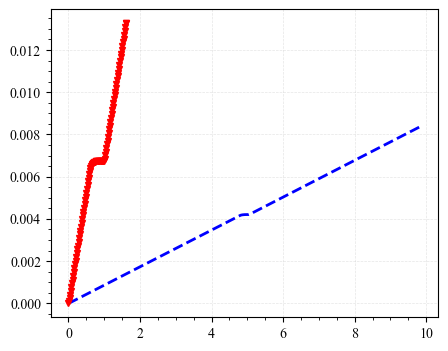

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
ax1 = axes
ax1.plot(t1,C_n1[0]-C_n1,'b--')
ax1.plot(t2,C_n2[0]-C_n2,'rv-')
# ax1.set_title(r'Mech Damage Cap loss $m_{LAM}$='+f'{mlam}')

plt.savefig(fig_DIR+'mech_dam_crate'+f'_mlam_1.png')

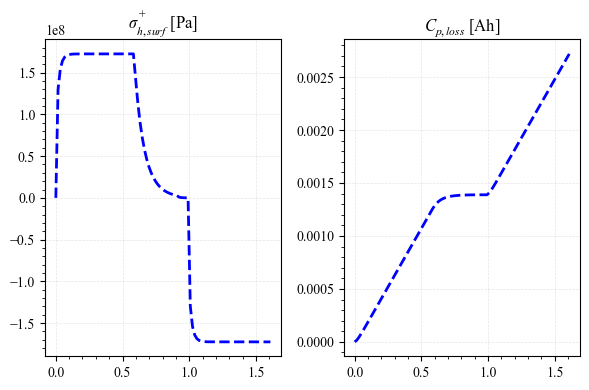

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax1 = ax.flat[0]
ax1.plot(t2,sigma_ts_p2,'b--')
ax1.set_title(r'$\sigma^+_{h,surf}$ [Pa]')
ax2 = ax.flat[1]
ax2.plot(t2,C_p2[0]-C_p2,'b--')
ax2.set_title(r'$C_{p,loss}$ [Ah]')
fig.tight_layout()
plt.savefig(fig_DIR+'positive_electrode_stress'+'.png')

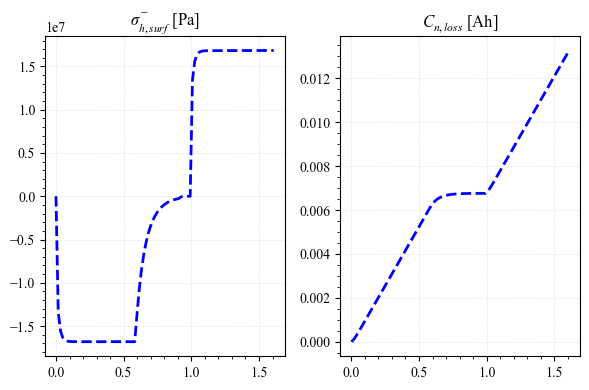

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax1 = ax.flat[0]
ax1.plot(t2,sigma_ts_n2,'b--')
ax1.set_title(r'$\sigma^-_{h,surf}$ [Pa]')
ax2 = ax.flat[1]
ax2.plot(t2,C_n2[0]-C_n2,'b--')
ax2.set_title(r'$C_{n,loss}$ [Ah]')
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'negative_electrode_stress'+'.png')

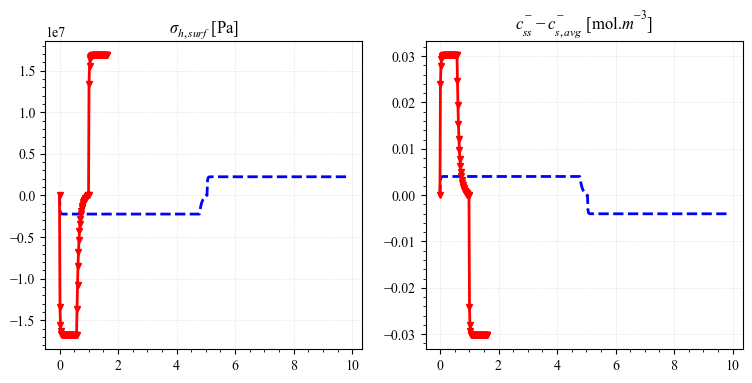

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax1 = axes.flat[0]
ax1.plot(t1,sigma_ts_n1,'b--')
ax1.plot(t2,sigma_ts_n2,'rv-')
ax1.set_title(r'$\sigma_{h,surf}$ [Pa]')
ax11 = axes.flat[1]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
plt.savefig(fig_DIR+'mech_stress_crate'+'.png')

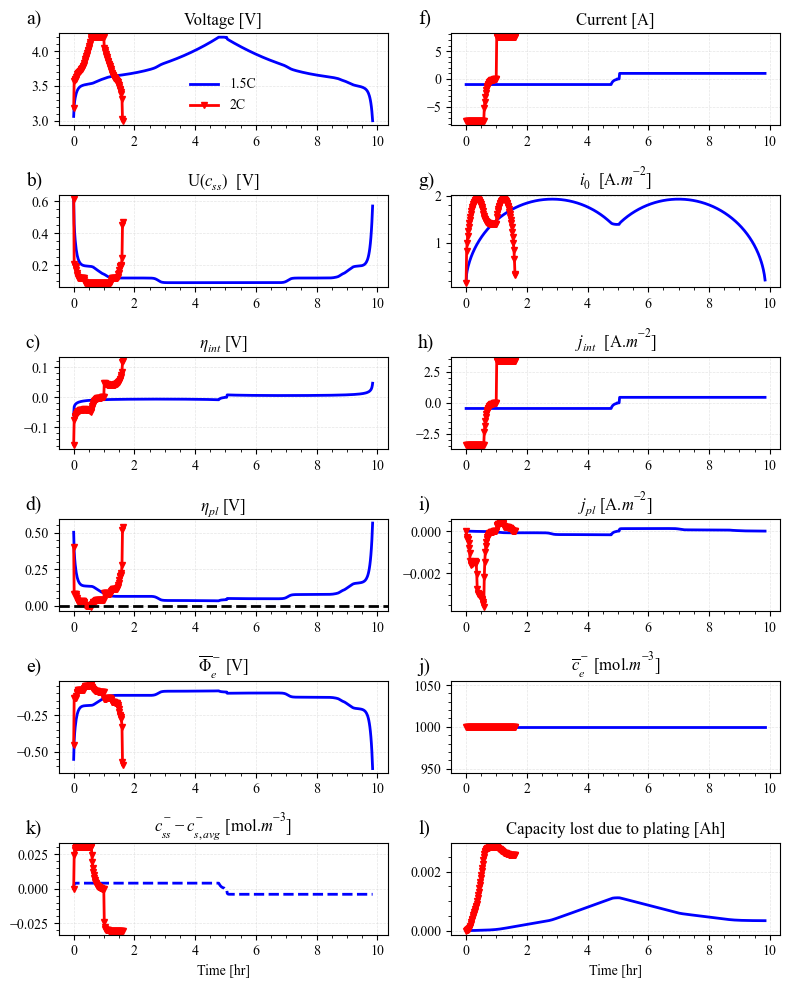

In [19]:

fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
# ax11.plot(t2,c_save_n2,'r--')
# ax11.legend(['surf','ave'])
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_new_2'+'.png')

In [20]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

-1.5166460443405885e-05
-0.0007121356698944144
46.9546386615236
7.6278000230346015


In [21]:
fgdfgd

NameError: name 'fgdfgd' is not defined

# Concentration Evolution

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1,'b')
ax.plot(t1/t1[-1],c_save_n1,'b--')
ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2/t2[-1],c_save_n2,'r--')
ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}$",r"C/5 $c_{s,ave}$",r"C/5 $c_{s,0}$",r"1.5C $c_{ss}$",r"1.5C $c_{s,ave}$",r"1.5C $c_{s,0}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_crate_comp_norm"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],u_css_n1,'b')
ax.plot(t2/t2[-1],u_css_n2,'r')
ax.legend(["C/5","1.5C"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Potential [V]")
ax.set_title(r'$U_n(c_{ss})$')
fig.savefig(fig_DIR+"neg_pot_crate_comp"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1-c_save_n1,'b')
# ax.plot(t1/t1[-1],c_save_n1-c_s_n1[0,:],'b--')
# ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2-c_save_n2,'r')
# ax.plot(t2/t2[-1],c_save_n2-c_s_n2[0,:],'r--')
# ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}-c_{s,avg}$",r"1.5C $c_{ss}-c_{s,avg}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration Difference $c_s$')

In [ ]:
len(t1)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t1,I1)
n=1
ax1.plot(t1[n],I1[n],'rx')
n=150
ax1.plot(t1[n],I1[n],'rx')
n=287
ax1.plot(t1[n],I1[n],'rx')
n=292
ax1.plot(t1[n],I1[n],'rx')
n=298
ax1.plot(t1[n],I1[n],'rx')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t2,I2)
n=1
ax1.plot(t2[n],I2[n],'rx')
n=18
ax1.plot(t2[n],I2[n],'rx')
n=36
ax1.plot(t2[n],I2[n],'rx')
n=46
ax1.plot(t2[n],I2[n],'rx')
n=56
ax1.plot(t2[n],I2[n],'rx')

In [ ]:
ln = np.linspace(0,1,20)
n = 1
print(t1[n]/60)
y1 = c_s_n1[:,n]
n = 10
y2 = c_s_n1[:,n]
n = 20
y3 = c_s_n1[:,n]
n = 30
y4 = c_s_n1[:,n]
n = 40
y5 = c_s_n1[:,n]
n = 50
y6 = c_s_n1[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
ax1.set_title(r'Negative Electrode $c_e-c_{e,ref}$ [mol.$m^{-3}$]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
# plt.savefig(fig_DIR+'dfn_c_e_5'+'.png')

In [ ]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

In [ ]:
sadas

In [ ]:
out = parameter_values.evaluate(0.75*param.F/param.R/298.15)
print(out)

# Compare Lithium Plating average vs seperator overpotential

In [ ]:
t1_e,V1_e,I1_e,Q1_e,Q_Li1_e,I_Li1_e,I_de1_e,I_st1_e,I_to1_e,phi_seif1_e,phi_sei1_e,phi_pl1_e,phi_del1_e,phi_ocp1_e,phi_int1_e,i0_int1_e,phi_e_avg1_e,c_e_avg1_e,c_ss_n1_e,c_save_n1_e,c_s_n1_e,u_css_n1_e,j_pl1_e,eta_pl1_e = plot_vars(solution1_e)
t2_e,V2_e,I2_e,Q2_e,Q_Li2_e,I_Li2_e,I_de2_e,I_st2_e,I_to2_e,phi_seif2_e,phi_sei2_e,phi_pl2_e,phi_del2_e,phi_ocp2_e,phi_int2_e,i0_int2_e,phi_e_avg2_e,c_e_avg2_e,c_ss_n2_e,c_save_n2_e,c_s_n2_e,u_css_n2_e,j_pl2_e,eta_pl2_e = plot_vars(solution2_e)

In [ ]:
# ln = np.linspace(0,1,20)
# fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
# # ax1.plot(t2_e,j_pl2_e[10,:])
# ax1.plot(ln,j_pl2_e[:,10])

In [ ]:
es_2 = solution2_e["X-averaged positive electrode active material volume fraction"].entries
R_n = parameter_values.evaluate(param.n.prim.R_typ)
F = parameter_values.evaluate(param.F)
j_pl2_max_e = j_pl2_e[-1,:]
nn = len(j_pl2_e)
j_pl2_a=0
eta_pl2_a=0
for i in range(nn):
    j_pl2_a+=j_pl2_e[i,:]
    eta_pl2_a+=eta_pl2_e[i,:]
j_pl2_av = j_pl2_a/nn
eta_pl2_av = eta_pl2_a/nn
d_c_lip_max = j_pl2_max_e
d_c_lip_av = j_pl2_av

eta_pl2_max_e = eta_pl2_e[-1,:]

as_2 = 3*es_2/R_n

mul =  parameter_values.evaluate(param.n.L*param.A_cc)
# mul =  parameter_values.evaluate(param.n.L)
mul2 = parameter_values.evaluate(param.n.L*param.L_y*param.L_z)
# mul2 = parameter_values.evaluate(param.L_z)

In [ ]:
Q_Li2_e_calc = -scipy.integrate.cumtrapz(d_c_lip_av*mul2*F,t2_e)
Q_Li2_e_calc = np.append(Q_Li2_e_calc,Q_Li2_e_calc[-1])

In [ ]:
Q_Li2_e_calc[-1] 

In [ ]:
Q_Li2_e[-1]

In [ ]:
fig, ax1= plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(t2_e,Q_Li2_e)
ax1.plot(t2_e,Q_Li2_e_calc)

In [ ]:
c_lip_max = scipy.integrate.cumtrapz(d_c_lip_max,t2_e)
c_lip_max = np.append(c_lip_max,c_lip_max[-1])
c_lip_av = scipy.integrate.cumtrapz(d_c_lip_av,t2_e)
c_lip_av = np.append(c_lip_av,c_lip_av[-1])

In [ ]:
Q_Li2_e_max =c_lip_max/c_lip_av*Q_Li2_e

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax1 = axes.flat[0]
ax1.plot(t2_e,j_pl2_av)
ax1.plot(t2_e,j_pl2_max_e,'--')
ax1.set_title("Plating Current")
ax1.set_ylabel(r"Current [A$m^{-2}$]")
ax1.set_xlabel("Time [hr]")
ax1.legend(["Average","Maximum"])
ax2 = axes.flat[1]
ax2.plot(t2_e,Q_Li2_e)
ax2.plot(t2_e,Q_Li2_e_max,'--')
ax2.set_title(R"$Q_{loss,pl}$")
ax2.set_ylabel(r"Capacity Loss [Ah]")
ax2.set_xlabel("Time [hr]")
ax3 = axes.flat[2]
ax3.plot(t2_e,eta_pl2_av)
ax3.plot(t2_e,eta_pl2_max_e,'--')
ax3.set_title(R"$\eta_{pl}$")
ax3.set_ylabel(r"Overpotential [V]")
ax3.set_xlabel("Time [hr]")
fig.tight_layout()
plt.savefig(fig_DIR+'impact_eta_plmax'+'.png')

In [ ]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2 = plot_vars(solution2)
fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'r')
# ax11.plot(t2,c_save_n2,'r--')
ax11.legend(['surf','ave'])
ax11.set_title(r'$c_s^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_high_irrev'+'.png')

In [ ]:
asdasd

In [ ]:
c_ss_n1

In [ ]:
c_smax_n = 28746
f1 = (c_ss_p1**0.5)*((c_smax_n-c_ss_p1)**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(t1,f1,'b')
# ax1.plot(t2,V2,'rv-')
ax1.set_title(r'$(c_{s,max}-c_{ss})^{1-\alpha}\times(c_{ss})^{\alpha}$')
ax1.set_xlabel("Time [hr]")
plt.savefig(fig_DIR+'exch_current_nonlinearity'+'.png')

In [ ]:
c_ss_p1 = np.linspace(1,0,51)

In [ ]:
c_smax_p =1
f1 = (c_ss_p1**0.05)*((c_smax_p-c_ss_p1)**0.05)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(c_ss_p1,f1,'b')
# ax1.plot(t2,V2,'rv-')
ax1.set_title(r'$(c_{s,max}-c_{ss})^{1-\alpha}\times(c_{ss})^{\alpha}$')
# plt.savefig(fig_DIR+'exch_current_nonlinearity'+'.png')